# Cleanse Anomalies in Saildrone Salinity Data

## This puts the CleanAnomalies project into one executable.

Enter Dataset Name with file extension (leave blank for default) 


No Entry Provided: Selected Default


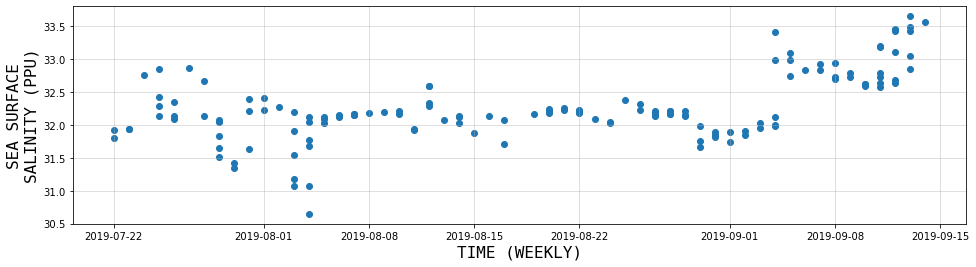

Filtered between 30 and 35 PPU


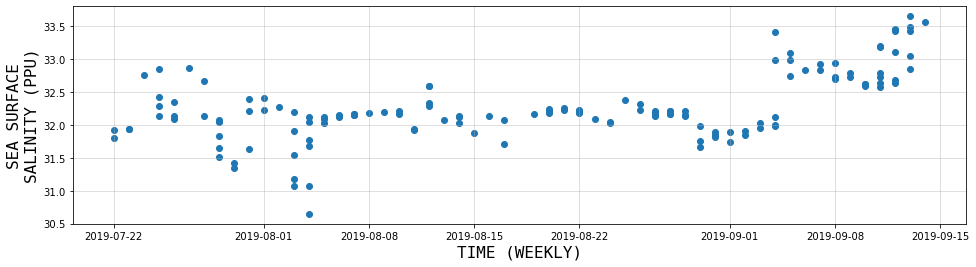

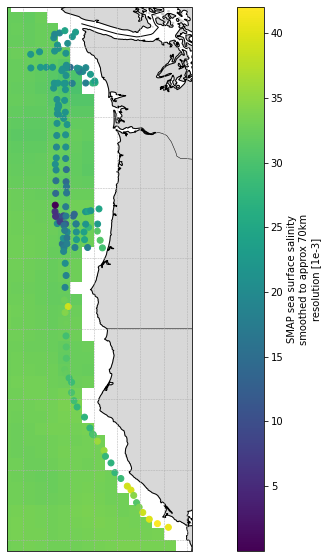

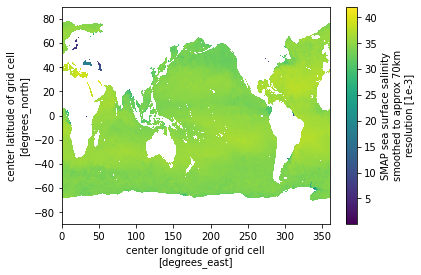

In [1]:
ddir = '~/shared/users/mgarciareyes/saildrone_data/'
fn = input("Enter Dataset Name with file extension (leave blank for default)")
if (not fn):
    print("No Entry Provided: Selected Default")
    fn = 'saildrone_west_coast_survey_2019_sd1044_JPLv5.0_8dy_20210613norep_20210613_20211116.nc'
fn

#import necessary packages
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
import datetime
import warnings
warnings.simplefilter('ignore') 

#load map packages
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from calendar import month_abbr

#open .nc file with Saildrone Data
sail = xr.open_dataset(ddir + fn) 
sail.close()

#copy data for calculations versus graphing
sail_raw = sail.copy()

sail

def filterSAL(min, max):
    sail['SAL_CTD_MEAN']=sail.SAL_CTD_MEAN.where(sail.SAL_CTD_MEAN>min, np.nan)
    sail['SAL_CTD_MEAN']=sail.SAL_CTD_MEAN.where(sail.SAL_CTD_MEAN<max, np.nan)
    return True

font = {
    'family': 'monospace',
    'color':  'k',
    'weight': 'normal',
    'size': 16,
}

def drawSAL():    
    #create plot 
    plt.figure(figsize=(16, 4))
    plt.scatter(x = sail['time'].dt.date, y = sail['SAL_CTD_MEAN']) #seaborn has built in confidence intervals
    # make temp/sal plot
    #add labels

    plt.grid(zorder=0, alpha=0.5)
    plt.xlabel('TIME (WEEKLY)', fontdict = font)
    plt.ylabel('SEA SURFACE\nSALINITY (PPU)', fontdict = font)
    plt.show()
    
# Remove Any Error Data
filterSAL(0, 9999)
drawSAL()

min_thresh = 30
max_thresh = 35

if (min_thresh & max_thresh):
    print("Filtered between " + str(min_thresh) + " and " + str(max_thresh) + " PPU")
    filterSAL(min_thresh, max_thresh)
drawSAL()

#file location of the sat data (there is also sat data in the saildrone? ask Gammon)
file_location = 'RSS_smap_SSS_L3_8day_running_2018_006_FNL_v04.0.nc4'

satSSS = xr.open_dataset(file_location)

satSSS

fig = plt.figure(figsize=(16,10), dpi = 72)
ax = plt.axes(projection=ccrs.PlateCarree())

#define latitude and longitude boundaries
latr = [min(sail['lat']), max(sail['lat'])] 
lonr = [max(sail['lon']), min(sail['lon'])] 

# Select a region of our data, giving it a margin
margin = 0.5 
region = np.array([[latr[0]-margin,latr[1]+margin],[lonr[0]+margin,lonr[1]-margin]]) 

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax.coastlines(resolution='10m',linewidth=1,color='black')
ax.add_feature(cfeature.LAND, color='grey', alpha=0.3)
ax.add_feature(states_provinces, linewidth = 0.5)
ax.add_feature(cfeature.BORDERS, color = 'black')
ax.set_extent([region[1,0],region[1,1],region[0,0],region[0,1]],crs=ccrs.PlateCarree()) 
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.gridlines(linestyle = '--', linewidth = 0.5)

satSSS['sss_smap'].plot()
#plot saildrone and sat data
plt.scatter(sail.lon, sail.lat, c = sail['SAL_CTD_MEAN'])

plt.show()

satSSS['sss_smap'].plot()